**NOTE**: this notebook has extra requirements, install them with:
```
pip install "error_parity[dev]"
```

In [1]:
import logging
from itertools import product

import numpy as np
import cvxpy as cp
from scipy.spatial import ConvexHull
from sklearn.metrics import roc_curve

## Given some data (X, Y, S)

In [2]:
def generate_groupwise_preds(n_samples, n_groups, prevalence, rng):
    
    # Different levels of gaussian noise per group
    group_noise = [0.25 + rng.random() for _ in range(n_groups)]

    # Generate predictions
    assert 0 < prevalence < 1
    y_score = rng.random(size=n_samples)

    # Generate labels
    # - define which samples belong to each group
    # - add different noise levels for each group
    group = rng.integers(low=0, high=n_groups, size=n_samples)
    
    y_true = np.zeros(n_samples)

    for i in range(n_groups):
        group_filter = group == i
        y_true_groupwise = ((
            y_score[group_filter] +
            rng.normal(size=np.sum(group_filter), scale=group_noise[i])
        ) > (1-prevalence)).astype(int)

        y_true[group_filter] = y_true_groupwise

    return y_true, y_score, group

In [3]:
N_GROUPS = 3
# N_SAMPLES = 10_000_000
N_SAMPLES = 1_000_000
# N_SAMPLES = 1_000

PREVALENCE = 0.25
SEED = 23

rng = np.random.default_rng(SEED)

y_true, y_score, group = generate_groupwise_preds(
    n_samples=N_SAMPLES,
    n_groups=N_GROUPS,
    prevalence=PREVALENCE,
    rng=rng)

# As we already have the y_scores, let's construct the
# features, X, as the index of the sample, so we can
# retrieve the generated score for each sample
X = np.arange(len(y_true))

In [4]:
actual_prevalence = np.sum(y_true) / len(y_true)
print(f"Actual global prevalence: {actual_prevalence:.1%}")

Actual global prevalence: 36.6%


In [5]:
EPSILON_TOLERANCE = 0.05
# EPSILON_TOLERANCE = 1.0  # best unconstrained classifier
FALSE_POS_COST = 1
FALSE_NEG_COST = 1

---
## Given a trained predictor (that outputs real-valued scores)

In [6]:
# Example predictor that predicts the synthetically produced scores above
predictor = lambda idx: y_score[idx]

## Construct the fair optimal classifier (derived from the given predictor)
- Fairness is measured by the equal odds constraint (equal FPR and TPR among groups);
    - optionally, this constraint can be relaxed by some small tolerance;
- Optimality is measured as minimizing the expected loss,
    - parameterized by the given cost of false positive and false negative errors;

In [7]:
# The error_parity package should be reachable (i.e., in python's path)
import sys
from pathlib import Path
sys.path.append(str(Path('..').resolve()))

In [8]:
from error_parity import RelaxedThresholdOptimizer

clf = RelaxedThresholdOptimizer(
    predictor=predictor,
    constraint="equalized_odds",
    tolerance=EPSILON_TOLERANCE,
    false_pos_cost=FALSE_POS_COST,
    false_neg_cost=FALSE_NEG_COST,
    max_roc_ticks=100,
    seed=SEED,
)

In [9]:
%%time
import logging
logging.basicConfig(level=logging.INFO, force=True)
clf.fit(X=X, y=y_true, group=group)

INFO:root:ROC convex hull contains 55.4% of the original points.
INFO:root:ROC convex hull contains 56.4% of the original points.
INFO:root:ROC convex hull contains 73.3% of the original points.
INFO:root:cvxpy solver took 0.000316875s; status is optimal.
INFO:root:Optimal solution value: 0.3366630539124823
INFO:root:Variable Global ROC point: value [0.09436774 0.24367746]
INFO:root:Variable ROC point for group 0: value [0.11270836 0.22648855]
INFO:root:Variable ROC point for group 1: value [0.11270836 0.23591624]
INFO:root:Variable ROC point for group 2: value [0.06270836 0.27648855]


CPU times: user 331 ms, sys: 16.2 ms, total: 347 ms
Wall time: 344 ms


## Plot solution

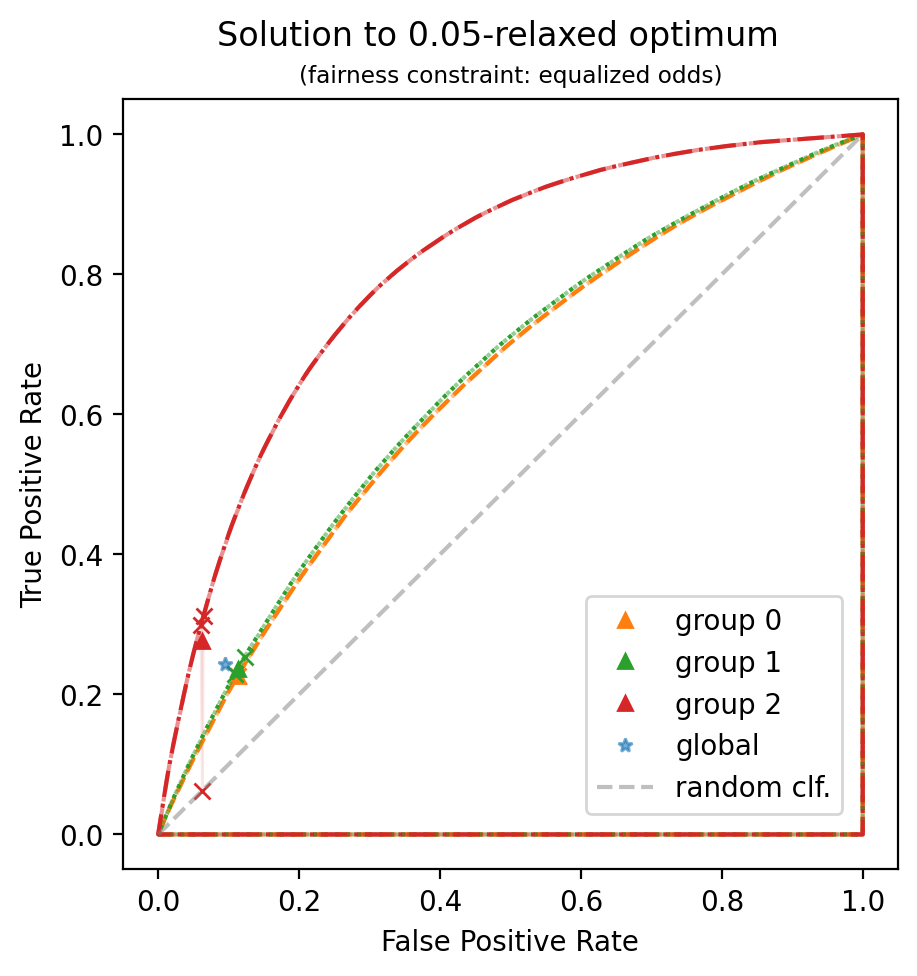

In [10]:
from matplotlib import pyplot as plt
from error_parity.plotting import plot_postprocessing_solution

plot_postprocessing_solution(
    postprocessed_clf=clf,
    plot_roc_curves=True,
    plot_roc_hulls=True,
    dpi=200, figsize=(5, 5),
)
plt.show()

---
## Plot realized ROC points
> realized ROC points will converge to the theoretical solution for larger datasets, but some variance is expected for smaller datasets

In [11]:
# Set group-wise colors and global color
import seaborn as sns
palette = sns.color_palette(n_colors=N_GROUPS + 1)
global_color = palette[0]
all_group_colors = palette[1:]

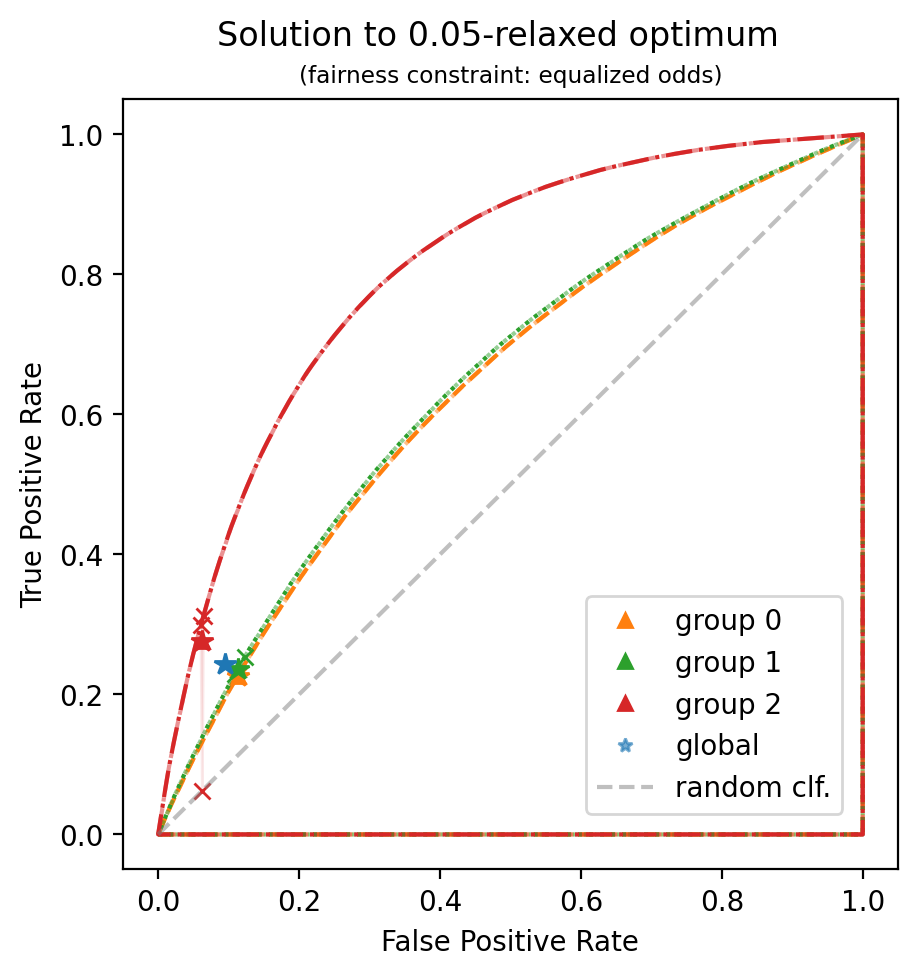

In [12]:
from error_parity.roc_utils import compute_roc_point_from_predictions

plot_postprocessing_solution(
    postprocessed_clf=clf,
    plot_roc_curves=True,
    plot_roc_hulls=True,
    dpi=200, figsize=(5, 5),
)

# Compute predictions
y_pred_binary = clf(X, group=group)

# Plot the group-wise points found
realized_roc_points = list()
for idx in range(N_GROUPS):

    # Evaluate triangulation of target point as a randomized clf
    group_filter = group == idx

    curr_realized_roc_point = compute_roc_point_from_predictions(y_true[group_filter], y_pred_binary[group_filter])
    realized_roc_points.append(curr_realized_roc_point)

    plt.plot(
        curr_realized_roc_point[0], curr_realized_roc_point[1],
        color=all_group_colors[idx],
        marker="*", markersize=8,
        lw=0,
    )

realized_roc_points = np.vstack(realized_roc_points)

# Plot actual global classifier performance
global_clf_realized_roc_point = compute_roc_point_from_predictions(y_true, y_pred_binary)
plt.plot(
    global_clf_realized_roc_point[0], global_clf_realized_roc_point[1],
    color=global_color,
    marker="*", markersize=8,
    lw=0,
)

plt.show()

### Compute distances between theorized ROC points and empirical ROC points

In [13]:
# Distances to group-wise targets:
for i, (target_point, actual_point) in enumerate(zip(clf.groupwise_roc_points, realized_roc_points)):
    dist = np.linalg.norm(target_point - actual_point, ord=2)
    print(f"Group {i}: l2 distance from target to realized point := {dist:.3%}")

# Distance to global target point:
dist = np.linalg.norm(clf.global_roc_point - global_clf_realized_roc_point, ord=2)
print(f"Global l2 distance from target to realized point   := {dist:.3%}")

Group 0: l2 distance from target to realized point := 0.000%
Group 1: l2 distance from target to realized point := 0.010%
Group 2: l2 distance from target to realized point := 0.056%
Global l2 distance from target to realized point   := 0.012%


### Compute performance differences
> assumes FP_cost == FN_cost == 1.0

In [14]:
from sklearn.metrics import accuracy_score
from error_parity.roc_utils import calc_cost_of_point

# Empirical
accuracy_val = accuracy_score(y_true, y_pred_binary)

# Theoretical
theoretical_global_cost = calc_cost_of_point(
    fpr=clf.global_roc_point[0],
    fnr=1 - clf.global_roc_point[1],
    prevalence=y_true.sum() / len(y_true),
)

print(f"Actual accuracy: \t\t\t{accuracy_val:.3%}")
print(f"Actual error rate (1 - Acc.):\t\t{1 - accuracy_val:.3%}")
print(f"Theoretical cost of solution found:\t{theoretical_global_cost:.3%}")

Actual accuracy: 			66.330%
Actual error rate (1 - Acc.):		33.670%
Theoretical cost of solution found:	33.666%


---

### Best non-fairness-constrained single-threshold solution

In [15]:
from tqdm.auto import tqdm
acc_unfair = max((accuracy_score(y_true, y_score >= t), t) for t in tqdm(np.arange(0, 1, 2e-2)))
print(f"Best unfair accuracy is {acc_unfair[0]:.3%}, with threshold t={acc_unfair[1]}")

  0%|          | 0/50 [00:00<?, ?it/s]

Best unfair accuracy is 67.260%, with threshold t=0.74
